In [2]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as ma
from numpy.linalg import inv
from ipywidgets import *
%matplotlib inline

# 0.- Los Datos elegidos.
####  Bueno yo tome una muestra de los datos observados del clima en España durante 704 días (desde 27 de mayo del 2017 - 27 de mayo del 2019), se pueden encontrar en el siguiente link : https://datosclima.es/Aemet2013/Tempestad2013.php.
#### Como variable a observar tome el Máximo de esos días.

In [3]:
df = pd.read_csv('Temperatura.csv', names=['Date', '# Days', 'Max', 'Min'])
df.head()

,Date,# Days,Max,Min
0,27/05/2017,2,20.2,15.5
1,28/05/2017,3,20.2,15.8
2,29/05/2017,4,19.6,15.8
3,30/05/2017,5,19.9,15.9
4,31/05/2017,6,21.1,15.2


#### Se tomaron como variables x = al número de observación de la temperatura, y a la variable y como el valor máximo de estas mismas(teníamos máximo y mínimo)

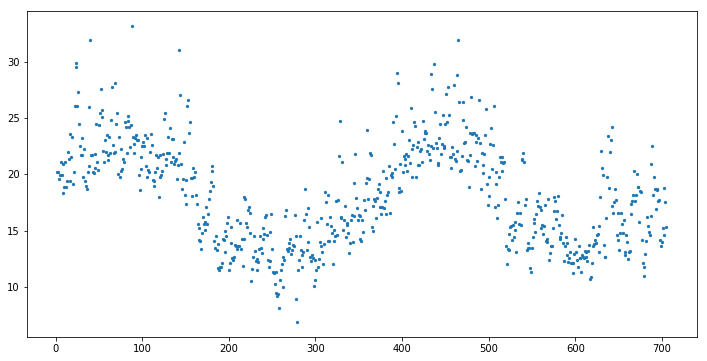

In [4]:
x = X = list(df['# Days'])
y = Y = list(df['Max'])
n = len(X)
plt.figure(figsize=(12,6))
plt.scatter(X,Y,s=5)

# 1.- Método de Suavizamiento.
## Se escogío el método de suavizamiento por splines.

In [11]:
def Spline1(l):
    n = len(x)
    K = len(Nots)
    X = np.matrix([[1] + [x[i]] + [max(x[i]-t,0) for t in Nots] for i in range(n)])
    D = np.matrix([[0 for i in range(K+2)],[0 for i in range(K+2)]]+[[(j==i-2)*1 for i in range(K+2)] for j in range(K)])
    b1 = y*(inv(X.T*X+(l**2)*D)*X.T).T
    b = list(b1.getA1())
    f = lambda x:b[0]+b[1]*x + sum(b[j+2]*max((x-Nots[j]),0) for j in range(K))
    plt.figure(figsize=(12,6))
    plt.scatter(x,y,s=5)
    plt.plot(np.arange(0,n,1),[f(x) for x in np.arange(0,n,1)],color="red")

#### Ahora para el valor los knots se escogieron de la siguiente forma.

In [10]:
Nots = [y for y in x if y%2 ==0]
interact(Spline1,l=(0.1,200))

interactive(children=(FloatSlider(value=100.05, description='l', max=200.0, min=0.1), Output()), _dom_classes=…

<function __main__.Spline1(l)>

# 2.- Valor $\lambda$ (usando validación cruzada).
#### La siguiente función R($\lambda$) está en función de $\lambda$ ( se escoge arbitrariamente), y nos va dando valores, esta función se tiene que minimizar para poder obtener el valor óptimo de $\lambda$ ; este puede variar de acuerdo a los datos y también de como se seleccionaron los knots.

In [12]:
def R(l):
    n = len(x)
    K = len(Nots)
    X = np.matrix([[1] + [x[i]] + [max(x[i]-t,0) for t in Nots] for i in range(n)])
    D = np.matrix([[0 for i in range(K+2)],[0 for i in range(K+2)]]+[[(j==i-2)*1 for i in range(K+2)] for j in range(K)])
    b1 = y*(inv(X.T*X+(l**2)*D)*X.T).T
    b = list(b1.getA1())
    L = X*(inv(X.T*X+(l**2)*D)*X.T)
    yu = []
    for m in range(n):
        yu.append(b[0]+b[1]*x[m]+sum(b[j+2]*max((x[m]-Nots[j]),0) for j in range(K)))
    F= []
    for i in range(n):
        F.append(((y[i]-yu[i])/(1-L[i,i]))**2)
    M=(1/n)*sum(F)  
    return M

#### Las variables que se muestran a continuación, en especial lambda_optimo nos otorga el valor óptimo de lambda con el cúal R(l) se minimiza. Tambíen podemos ver la gráfica del comportamiento de $\lambda$

In [15]:
H = [R(i) for i in np.arange(0.1,200,0.1)]

In [30]:
lambda_optimo = (np.argmin(H)+1)*0.1

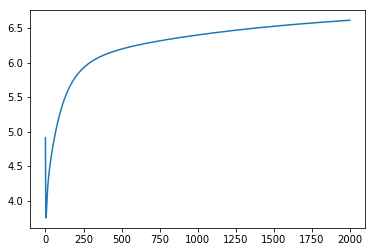

In [18]:
plt.plot(H)

In [40]:
lambda_optimo

0.5

# 3.- Estimar  $\overline{\sigma_{x}}^{2}$
#### Para obtener $\sigma_{x}^{2}$, para $\overline{r_{n}}(x_{i})$ se escogio $\lambda = 0.5$, porque es el valor que lo minimiza. Adémas la fórmula que use para estimar $\overline{\sigma}^{2}$, se puede encontrar en el libro $"All~of~Non~Parametric~Statistics~~-~~Larry~Waserman~~-~~Pág~85$.

In [89]:
def var(l):
    n = len(x)
    K = len(Nots)
    X = np.matrix([[1] + [x[i]] + [max(x[i]-t,0) for t in Nots] for i in range(n)])
    D = np.matrix([[0 for i in range(K+2)],[0 for i in range(K+2)]]+[[(j==i-2)*1 for i in range(K+2)] for j in range(K)])
    b1 = y*(inv(X.T*X+(l**2)*D)*X.T).T
    b = np.array(list(b1.getA1()))
    L = X*(inv(X.T*X+(l**2)*D)*X.T)
    V = (L.T)*L
    v = []
    for j in range(len(L)):
        v.append(L[j,j])
    trazaL = sum(v)
    v1 = []
    for j in range(len(V)):
        v1.append(V[j,j])
    trazaL1 = sum(v1)
    yu = []
    for m in range(n):
        yu.append(b[0]+b[1]*x[m]+sum(b[j+2]*max((x[m]-Nots[j]),0) for j in range(K)))
    F = []
    for i in range(n):
        F.append((y[i]-yu[i])**2)
    G = sum(F)
    var = G/(n-2*trazaL+trazaL1)
    return var

In [90]:
var(0.5)

2.591421764215183

# 4.- Bandas de Confianza.
### Para estimar las bandas de confianza igual se utilizo el libro ya antes mencionado, solo que para obtener las bandas de confiaza se uso la definición de estas que viene en la página 89.

In [101]:
def bandas(l,c):
    n = len(x)
    K = len(Nots)
    X = np.matrix([[1] + [x[i]] + [max(x[i]-t,0) for t in Nots] for i in range(n)])
    D = np.matrix([[0 for i in range(K+2)],[0 for i in range(K+2)]]+[[(j==i-2)*1 for i in range(K+2)] for j in range(K)])
    b1 = y*(inv(X.T*X+(l**2)*D)*X.T).T
    b = list(b1.getA1())
    L = X*(inv(X.T*X+(l**2)*D)*X.T)
    V = (L.T)*L
    v = []
    for j in range(len(L)):
        v.append(L[j,j])
    trazaL = sum(v)
    v1 = []
    for j in range(len(V)):
        v1.append(V[j,j])
    trazaL1 = sum(v1)
    yu = []
    for m in range(n):
        yu.append(b[0]+b[1]*x[m]+sum(b[j+2]*max((x[m]-Nots[j]),0) for j in range(K)))
    F = []
    for i in range(n):
        F.append((y[i]-yu[i])**2)
    G = sum(F)
    var = G/(n-2*trazaL+trazaL1)
    sup = []
    for e in range(n):
        sup.append(yu[e]+c*np.sqrt(var))
    mini = []
    for e in range(n):
        mini.append(yu[e]-c*np.sqrt(var))
    plt.figure(figsize=(12,6))
    plt.scatter(x,y,s=5)
    plt.plot(np.arange(0,n,1),yu,color="red")
    plt.plot(np.arange(0,n,1),sup, color = "black")
    plt.plot(np.arange(0,n,1),mini, color = "orange")

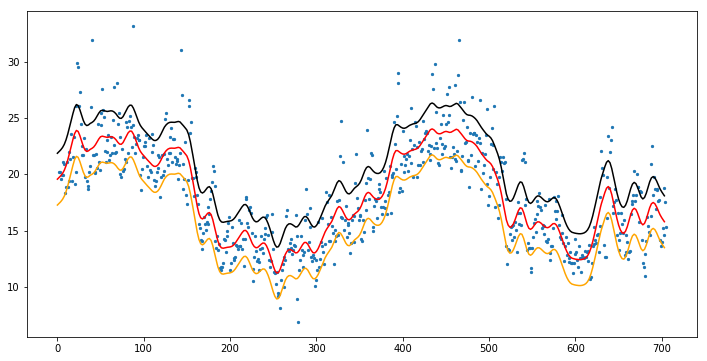

In [105]:
bandas(15,1)

# Conclusiones:
### Este trabajo, me hizo entender varias cosas, desde lo que nos otorga un suavizamiento lineal, que en pocas palabras para mi es como determinar el comportamiento de una función entre dos knots o puntos, pero tomando en cuenta los datos, y esto depende mucho, de los datos, de los knots y del valor de $\lambda$.
### Para obtener el valor óptimo de $\lambda$ se uso validación cruzada, también grafique los valores de R($\lambda$) con respecto de lambda y me dio como una función en forma de v, que podemos ver el valor de $\lambda$ con el cúal se minimizaba, y esto se parece a la gráfica que usted también puso en clase. Está gráfica también depende de los datos.
### En la última parte, en la banda de confianza el valor c puede hacer que la banda sea mas ancha o mas delgada.
### Pero sobre todo se uso principalmente el programa que usted subió como base, los apuntes y como complementos los libros que nos recomendo. 